In [1]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
def as_step(name):
    renames = {'A*s': 'CG0',
               'alpha = (r*r) / s*A*s': 'CG1',
               'x += s * alpha': 'CG2',
               'r -= temp * alpha': 'CG3',
               'r*r': 'CG4',
               'sk+1 = rk+1 + beta * sk;': 'CG5',
               'distributing s': 'DCG1',
               'edge sync': 'DCG0',
               }
    return renames.get(name, name)


def make_steps(steps):
    return {as_step(name): value for name, value in steps.items()}


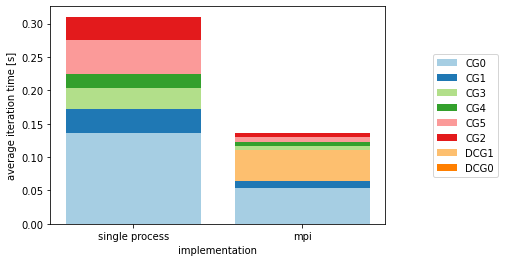

In [3]:
import json
from pathlib import Path


def load_json(path):
    with open(path) as fin:
        return json.load(fin)


def load_stats(directory):
    directory = Path('../../resources/benchmark_data') / Path(directory)
    files = [*directory.glob("stats*.json")]

    result = load_json(files[0])

    if len(files) > 1:
        for file in files[1:]:
            j = load_json(file)
            result["total"] += j["total"]

            for step, length in j["cg"]["steps"].items():
                result["cg"]["steps"][step] += length
            result["cg"]["total"] += j["cg"]["total"]

    result["total"] /= len(files)
    for step, length in result["cg"]["steps"].items():
        result["cg"]["steps"][step] /= len(files)
    result["cg"]["total"] /= len(files)

    result['cg']['steps'] = make_steps(result['cg']['steps'])

    return result


def normalize(stats):
    other = stats["cg"]["total"] - sum(stats["cg"]["steps"].values())
    if other / stats["cg"]["total"] > 0.01:
        stats["cg"]["steps"]["other"] = other

    for key in stats["cg"]["steps"]:
        stats["cg"]["steps"][key] /= stats["cg"]["num_iters"]

    stats['cg']['steps'] = make_steps(stats['cg']['steps'])

    return stats


def get_color(step, next_color=[0], colors={}):
    if step not in colors:
        colors[step] = plt.cm.Paired(next_color)
        next_color[0] += 1

    return colors[step]


def plot_one(ax, stats, offset):
    bottom = 0
    for step, value in stats["cg"]["steps"].items():
        ax.bar(
            offset, value, bottom=bottom, label=step, width=0.4, color=get_color(step)
        )
        bottom += value


def plot_run(matrix="gap-web", layout="8-1-8", st=None):

    dim = load_stats(
        f"cg_dim/{matrix}/{layout}")
    dim2 = load_stats(
        f"cg_dim2/{matrix}/{layout}")
    petsc = load_stats(
        f"cg_petsc/{matrix}/{layout}")

    normalize(dim)
    normalize(dim2)
    normalize(petsc)

    fig, ax = plt.subplots(1, 1)

    if st is not None:
        st_ds = load_stats(
            f"cg_dim_st/{matrix}/{st}")
        normalize(st_ds)
        plot_one(ax, st_ds, 0)

    #plot_one(ax, dim, 0)
    plot_one(ax, dim2, 0.5)
    #plot_one(ax, petsc, 1)

    nodes, tasks_per_node, threads = layout.split("-", maxsplit=3)

    ax.set_xticks(np.arange(2) * 0.5, ["single process", "mpi", ])
    ax.set_xlabel("implementation")
    ax.set_ylabel("average iteration time [s]")
    # ax.set_title(
    #    f"Average iteration time of conjugate gradient ({nodes} nodes, {tasks_per_node} tasks per node, {threads} threads per task)"
    # )

    handles, labels = fig.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    lgd = fig.legend(
        by_label.values(), by_label.keys(), loc="center left", bbox_to_anchor=(1, 0.5)
    )

    fig.savefig('mpi_vs_st.pdf', bbox_extra_artists=(
        lgd,), bbox_inches='tight')


st_mpi = load_stats(f"cg_dim2/gap-web/4-1-32")
st_ds = load_stats(f"cg_dim_st/gap-web/128")
normalize(st_ds)


#fig1, ax1 = plt.subplots()
# ax1.pie(st_ds['cg']['steps'].values(), labels=st_ds['cg']['steps'].keys(), autopct='%1.1f%%',
#        shadow=False, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle.
# ax1.axis('equal')
# fig1.savefig('cg_steps.png')
# fig1.show()
#
#fig2, ax2 = plt.subplots()
# ax2.pie([st_ds['cg']['total'], st_ds['io']], labels=['conjugate gradient', 'matrix loading'], autopct='%1.1f%%',
#        shadow=False, startangle=90)
# ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# fig2.savefig('io_sequential_h5.png')
# fig2.show()

# plot_run(layout="4-2-8")
#plot_run(layout="4-1-16", st='64')
plot_run(layout="4-1-32", st='128')
# plot_run(layout="8-1-4")
#plot_run(layout="8-1-8", st='64')
#plot_run(layout="8-1-16", st='128')
#plot_run(layout="8-1-32", st='128')


In [4]:
def load_sp_stats_impl(mat, cpu_count):
    return normalize(load_json(
        f'../../resources/benchmark_data/cg_dim_st/{mat}/{cpu_count}/stats.json'))


def load_sp_stats(mat):
    return {cpu_count: load_sp_stats_impl(mat, cpu_count) for cpu_count in map(lambda path: path.parts[-1], Path(f'../../resources/benchmark_data/cg_dim_st/{mat}').glob('*'))}


def plot_sp_one(ax, ds, layouts):
    layouts = sorted(layouts, key=int)
    for i, layout in enumerate(layouts):
        plot_one(ax, ds[layout], 0.5 * i)

    ax.set_xticks(np.arange(len(layouts)) * 0.5,
                  map(lambda layout: str(layout), layouts))


def plot_sp(ds, layouts={'16', '32', '64', '128'}):
    fig, axes = plt.subplots(1, len(ds), figsize=(10, 5))
    for i, (matrix, data) in enumerate(ds.items()):
        axes[i].set_title(matrix)
        plot_sp_one(axes[i], data, layouts)

    supx = fig.supxlabel("#CPUs")
    supy = fig.supylabel("average iteration time [s]")
    handles, labels = fig.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    lgd = fig.legend(
        by_label.values(), by_label.keys(), loc="center", bbox_to_anchor=(1, 0.5)
    )
    fig.savefig('single_process.pdf', bbox_extra_artists=(
        lgd, supx, supy,), bbox_inches='tight')


def plot_pie(ds):
    fig1, ax1 = plt.subplots()
    ax1.pie(ds['cg']['steps'].values(), labels=ds['cg']['steps'].keys(), colors=[get_color(step) for step in ds['cg']['steps'].keys()], autopct='%1.1f%%',
            shadow=False, startangle=90)
    ax1.axis('equal')
    
    return fig1


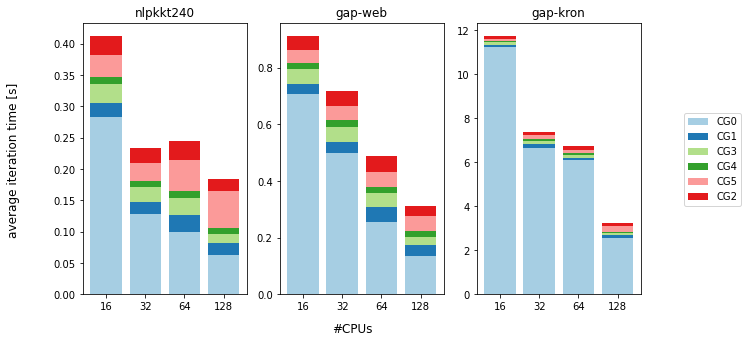

In [5]:
sp_stats = {matrix: load_sp_stats(matrix) for matrix in [
    'nlpkkt240', 'gap-web', 'gap-kron']}
plot_sp(sp_stats)

In [6]:
def load_mpi_stats_impl(directory):
    directory = Path('../../resources/benchmark_data') / Path(directory)
    files = [*directory.glob("stats*.json")]
    result = load_json(files[0])
    if (len(files) < 2):
        return result

    for stat_file in files[1:]:
        data = load_json(stat_file)
        csteps = result['cg']['steps']
        steps = data['cg']['steps']

        curr_spmv_time = csteps['A*s']
        spmv_time = data['cg']['steps']['A*s']

        # adjust the result, the sync time is valid only from the longest running node.
        if spmv_time > curr_spmv_time:
            result['cg']['steps']['A*s'] = spmv_time
            result['cg']['steps']['alpha = (r*r) / s*A*s'] = steps['alpha = (r*r) / s*A*s']

        x_st = steps['x += s * alpha']
        r_st = steps['r -= temp * alpha']
        # only take r*r sync time from node which arrived to it last.
        if (x_st + r_st) > csteps['x += s * alpha'] + csteps['r -= temp * alpha']:
            result['cg']['steps']['x += s * alpha'] = x_st
            result['cg']['steps']['r -= temp * alpha'] = r_st
            result['cg']['steps']['r*r'] = steps['r*r']

        s_st = steps['sk+1 = rk+1 + beta * sk;']
        if s_st > csteps['sk+1 = rk+1 + beta * sk;']:
            result['cg']['steps']['sk+1 = rk+1 + beta * sk;'] = s_st
            result['cg']['steps']['distributing s'] = steps['distributing s']

    return result


def load_mpi_stats(mat):
    mat_dir = Path(f'../../resources/benchmark_data/cg_dim2/{mat}')
    return {layout: normalize(load_mpi_stats_impl(f'cg_dim2/{mat}/{layout}'))
            for layout in map(lambda path: path.parts[-1], mat_dir.glob('*'))}


def plot_mt_one(ax, ds, layouts={'2-1-64', '4-1-32', '8-1-16'}):
    layouts = sorted(layouts, key=lambda x: [*map(int, x.split('-'))])
    for i, layout in enumerate(layouts):
        plot_one(ax, ds[layout], 0.5 * i)

    ax.set_xticks(np.arange(len(layouts)) * 0.5, layouts)


from copy import deepcopy

def plot_mt(ds, layouts: set = {'2-1-64', '4-1-32', '8-1-16'}, file_to_save=None, with_sp=False):
    fig, axes = plt.subplots(1, len(ds), figsize=(10, 4))

    for i, (matrix, data) in enumerate(ds.items()):
        if with_sp:
            data = deepcopy(data)
            data['1-1-128'] = sp_stats[matrix]['128']
            layouts.add('1-1-128')
        axes[i].set_title(matrix)
        plot_mt_one(axes[i], data, layouts)

    supx = fig.supxlabel("layout")
    supy = fig.supylabel("average iteration time [s]")

    handles, labels = fig.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    lgd = fig.legend(
        by_label.values(), by_label.keys(), loc="center", bbox_to_anchor=(1, 0.5)
    )

    if file_to_save is not None:
        fig.savefig(file_to_save, bbox_extra_artists=(
            lgd, supx, supy,), bbox_inches='tight')


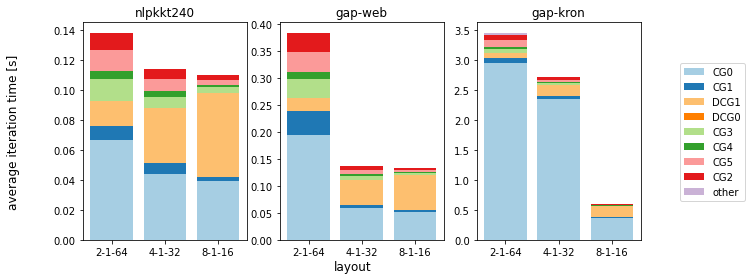

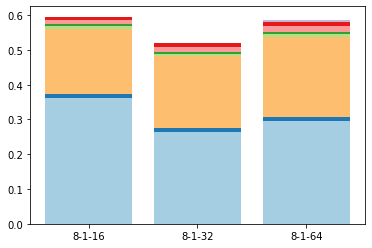

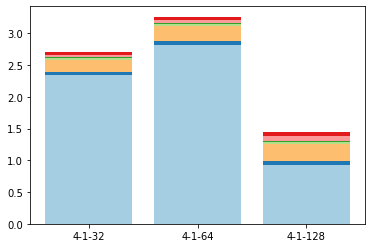

In [7]:
cg_dim_ds = {matrix: load_mpi_stats(matrix) for matrix in [
    'nlpkkt240', 'gap-web', 'gap-kron']}

plot_mt(cg_dim_ds, file_to_save='mpi.pdf')
plot_mt_one(plt.subplots()[1], cg_dim_ds['gap-kron'],
            {'8-1-16', '8-1-32', '8-1-64'})

plot_mt_one(plt.subplots()[1], cg_dim_ds['gap-kron'],
            {'4-1-32', '4-1-64', '4-1-128'})


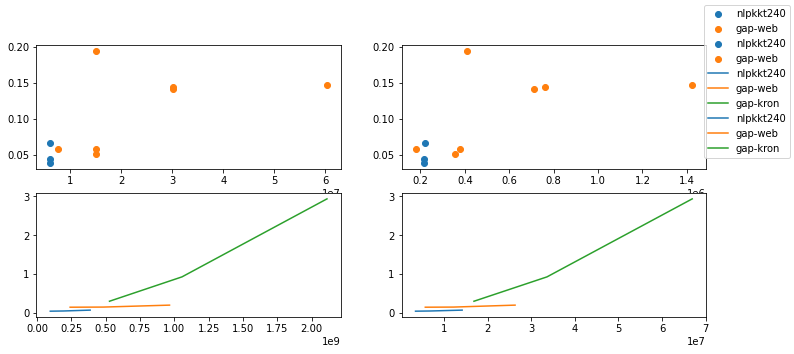

In [8]:
res = {'epc': {}, 'rpc': {}, 'el': {}, 'rw': {}}
for matrix, run in cg_dim_ds.items():
    # print(matrix)
    mat_epc = res['epc'].setdefault(matrix, {})
    mat_rpc = res['rpc'].setdefault(matrix, {})
    mat_el = res['el'].setdefault(matrix, {})
    mat_rw = res['rw'].setdefault(matrix, {})
    for layout, data in run.items():
        gen_info = data["general_info"]
        cpus = int(layout.split('-')[2])
        #print(f' {layout} {data["cg"]["steps"]["A*s"]}')
        if 'local_elements' in gen_info:
            elems_per_cpu = gen_info["local_elements"] / cpus
            rows_per_cpu = gen_info["local_rows"] / cpus
            mat_epc[elems_per_cpu] = data['cg']['steps'][as_step('A*s')]
            mat_rpc[rows_per_cpu] = data['cg']['steps'][as_step('A*s')]
            mat_el[gen_info["local_elements"]] = data['cg']['steps'][as_step('A*s')]
            mat_rw[gen_info["local_rows"]] = data['cg']['steps'][as_step('A*s')]
            #print(f'  local_elems : {gen_info["local_elements"]} {elems_per_cpu}')
            #print(f'  loc_rows    : {gen_info["local_rows"]}     {rows_per_cpu}')


fig, ax = plt.subplots(2, 2,  figsize=(12, 5))
for mat, dat in res['epc'].items():
    if mat == 'gap-kron':
        continue
    ax[0][0].scatter(dat.keys(), dat.values(), label=mat)
for mat, dat in res['rpc'].items():
    if mat == 'gap-kron':
        continue
    ax[0][1].scatter(dat.keys(), dat.values(), label=mat)
for mat, dat in res['el'].items():
    ds = sorted(dat, key=lambda x: dat[x])
    ax[1][0].plot(ds, [*map(lambda x: dat[x], ds)], label=mat)
for mat, dat in res['rw'].items():
    ds = sorted(dat, key=lambda x: dat[x])
    ax[1][1].plot(ds, [*map(lambda x: dat[x], ds)], label=mat)
fig.legend()


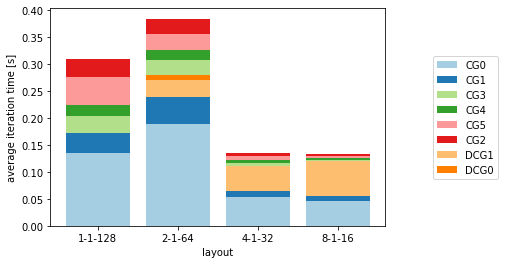

In [9]:
ds = {'1-1-128': normalize(load_stats('cg_dim_st/gap-web/128'))}

ds = {**ds, **{layout: normalize(load_stats(f'cg_dim2/gap-web/{layout}'))
      for layout in ['2-1-64', '4-1-32', '8-1-16']}}


fig, ax = plt.subplots()

for i, (name, stats) in enumerate(ds.items()):
    plot_one(ax, stats, 0.5 * i)

ax.set_xticks(np.arange(len(ds)) * 0.5, ds.keys())
ax.set_xlabel("layout")
ax.set_ylabel("average iteration time [s]")
# ax.set_title(
#    f"Average iteration time of conjugate gradient ({nodes} nodes, {tasks_per_node} tasks per node, {threads} threads per task)"
# )

handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
lgd = fig.legend(
    by_label.values(), by_label.keys(), loc="center left", bbox_to_anchor=(1, 0.5)
)
fig.savefig('layout.pdf', bbox_extra_artists=(
    lgd,), bbox_inches='tight')


{'nlpkkt240': {1: 3.4081466883242135, 4: 6.023387095687701, 2: 3.439537890942959, 8: 8.551225494413202}, 'gap-web': {1: 1.9997335774985359, 4: 5.4232463002043465, 2: 2.429576234134313, 8: 11.28987574805781}, 'gap-kron': {1: 1.8163107433332013, 4: 4.996331581433802, 2: 2.8800099555692777, 8: 12.5260424126906}}


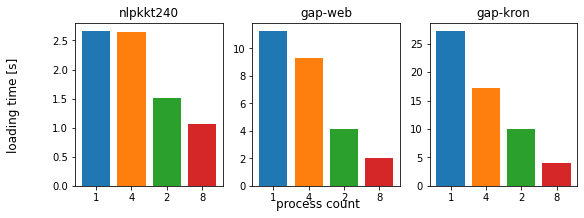

In [10]:
io_stats = {matrix_dir.parts[-1]: {data.get('process_count', 1): data['avg'] for data in map(
    load_json, matrix_dir.glob('*.json'))} for matrix_dir in Path('../../resources/benchmark_data/io').glob('*')}

matrix_sizes = {'nlpkkt240': 9762418948.,
                'gap-web': 24235139424.,
                'gap-kron': 53213206960.}


throughput = {matrix: {np: (size / (1024 ** 3)) / time for np,
                       time in io_stats[matrix].items()} for matrix, size in matrix_sizes.items()}

fig, axes = plt.subplots(1, 3, figsize=(9, 3))

for i, matrix in enumerate(matrix_sizes.keys()):
    data = io_stats[matrix]
    ax = axes[i]

    for j, (proc, time) in enumerate(sorted(data.items())):
        ax.bar(0.5*j, time, label=proc, width=0.4)

    ax.set_title(matrix)
    ax.set_xticks(np.arange(len(data)) * 0.5, data.keys())


#handles, labels = fig.gca().get_legend_handles_labels()
#by_label = dict(zip(labels, handles))
# lgd = fig.legend(
#    by_label.values(), by_label.keys(), loc="center left", bbox_to_anchor=(1, 0.5)
# )

supx = fig.supxlabel("process count")
supy = fig.supylabel("loading time [s]")
fig.savefig('io_all.pdf', bbox_extra_artists=(supx, supy), bbox_inches='tight')
print(throughput)


{'nlpkkt240': {1: 3.4081466883242135, 4: 6.023387095687701, 2: 3.439537890942959, 8: 8.551225494413202}, 'gap-web': {1: 1.9997335774985359, 4: 5.4232463002043465, 2: 2.429576234134313, 8: 11.28987574805781}, 'gap-kron': {1: 1.8163107433332013, 4: 4.996331581433802, 2: 2.8800099555692777, 8: 12.5260424126906}}


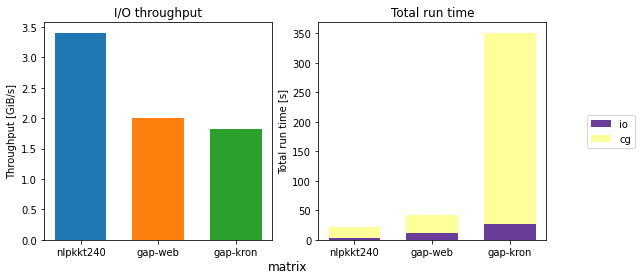

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(9,4))
print(throughput)
for i, matrix in enumerate(matrix_sizes.keys()):
    io_data = io_stats[matrix]
    tp_data = throughput[matrix]
    sp_data = sp_stats[matrix]
    ax[1].bar(i*0.3, io_data[1], width=0.2, label='io', color=get_color('io'))
    ax[1].bar(i*0.3, sp_data['128']['cg']['total'],
           bottom=io_data[1], width=0.2, color=get_color('cg'), label='cg')
    ax[0].bar(i*0.3, tp_data[1], width=0.2, label='x')
    #print(matrix, io_data[8] / (io_data[8] + sp_data[matrix]['128']['cg']['total']))


ax[0].set_title('I/O throughput')

ax[1].set_title('Total run time')

ax[1].set_ylabel('Total run time [s]')
ax[0].set_ylabel('Throughput [GiB/s]')

ax[1].set_xticks(np.arange(len(matrix_sizes)) * 0.3, matrix_sizes.keys())
ax[0].set_xticks(np.arange(len(matrix_sizes)) * 0.3, matrix_sizes.keys())

supy = fig.supxlabel('matrix')
handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
lgd = fig.legend(
    by_label.values(), by_label.keys(), loc="center", bbox_to_anchor=(1, 0.5)
)

fig.savefig('io.pdf', bbox_extra_artists=(lgd, supy), bbox_inches='tight')

[2]


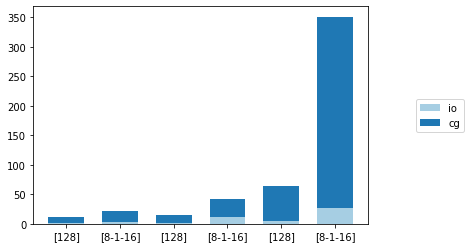

In [12]:
fig, ax = plt.subplots()

labels_ = []
cls = [0]
colors = {}
for i, matrix in enumerate(matrix_sizes.keys()):
    io_data = io_stats[matrix]
    mp_data = cg_dim_ds[matrix]
    sp_data = sp_stats[matrix]
    ax.bar(i*0.3*2+0.3, io_data[1], width=0.2,
           color=get_color('io', cls, colors), label='io')
    ax.bar(i*0.3*2+0.3, sp_data['128']['cg']['total'],
           bottom=io_data[1], width=0.2, color=get_color('cg', cls, colors), label='cg')

    ax.bar(i*0.3*2, io_data[8], width=0.2,
           color=get_color('io', cls, colors), label='io')
    ax.bar(i*0.3*2, mp_data['8-1-16']['cg']['total'],
           bottom=io_data[8], width=0.2, color=get_color('cg', cls, colors), label='cg')
    labels_.extend([f'[128]', f'[8-1-16]'])
print(cls)

ax.set_xticks(np.arange(len(labels_)) * 0.3, labels_)
handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
lgd = fig.legend(
    by_label.values(), by_label.keys(), loc="center left", bbox_to_anchor=(1, 0.5)
)


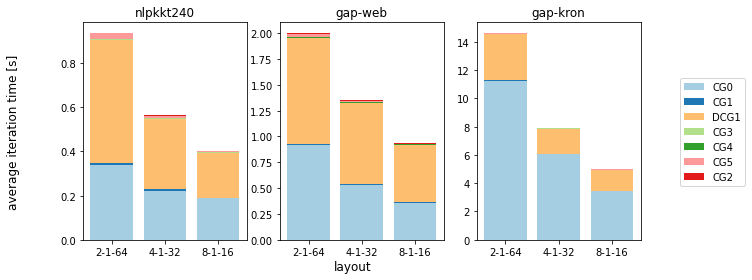

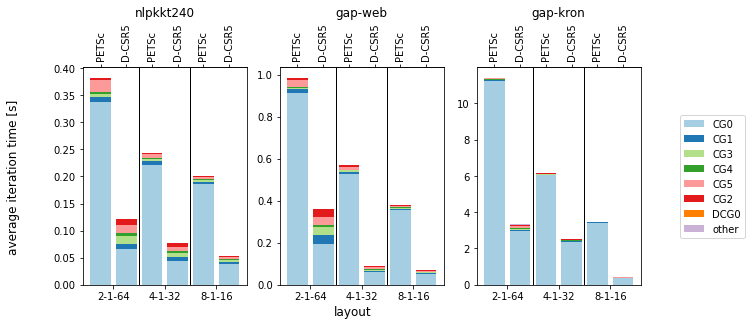

In [16]:

def load_p_stats(mat):
    mat_dir = Path(f'../../resources/benchmark_data/cg_petsc/{mat}')
    return {layout: normalize(load_mpi_stats_impl(f'cg_petsc/{mat}/{layout}'))
            for layout in map(lambda path: path.parts[-1], mat_dir.glob('*'))}


def plot_p_one(ax, name, ds, layouts={'2-1-64', '4-1-32', '8-1-16'}):
    layouts = sorted(layouts, key=lambda x: [*map(int, x.split('-'))])
    ax.set_title(name)
    for i, layout in enumerate(layouts):
        ds_l = deepcopy(ds[layout])
        ds_r = deepcopy(cg_dim_ds[name][layout])
        
        del ds_l['cg']['steps'][as_step('distributing s')]
        plot_one(ax, ds_l, 1 * i)

        
        del ds_r['cg']['steps'][as_step('distributing s')]
        plot_one(ax, ds_r, 1 * i + 0.5)

    ax.set_xticks(np.arange(3) + 0.25, layouts)

    for x in np.arange(2) + 0.74:
        ax.axvline(x, linewidth=1, color='black')

    sec_x = ax.secondary_xaxis(1)
    sec_x.set_ticks(np.arange(len(layouts) * 2) * 0.5, ['PETSc', 'D-CSR5'] * 3, rotation='vertical')


def plot_p(ds, layouts: set = {'2-1-64', '4-1-32', '8-1-16'}):
    fig, axes = plt.subplots(1, len(ds), figsize=(10, 4))

    for i, (matrix, data) in enumerate(ds.items()):
        plot_p_one(axes[i], matrix, data, layouts)

    supx = fig.supxlabel("layout")
    supy = fig.supylabel("average iteration time [s]")

    handles, labels = fig.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    lgd = fig.legend(
        by_label.values(), by_label.keys(), loc="center", bbox_to_anchor=(1, 0.5)
    )

    fig.savefig('petsc_vs_dim.pdf', bbox_extra_artists=(
        lgd, supx, supy), bbox_inches='tight')


petsc_stats = {matrix: load_p_stats(matrix) for matrix in [
    'nlpkkt240', 'gap-web', 'gap-kron']}

plot_mt(petsc_stats, file_to_save='petsc_mpi.pdf', with_sp=False)
plot_p(petsc_stats)



In [ ]:
for matrix, p_layouts in petsc_stats.items():
    dim_layouts = cg_dim_ds[matrix]
    print(matrix)
    for layout, p_data in p_layouts.items():
        dim_data = dim_layouts[layout]
        p_sum = sum(p_data['cg']['steps'].values())
        dim_sum = sum(dim_data['cg']['steps'].values())
        p_mv = p_data['cg']['steps']['A*s']
        # + dim_data['cg']['steps']['edge sync']
        dim_mv = dim_data['cg']['steps']['A*s']
        print(f' {layout} & {p_sum/dim_sum:.3} & {p_mv/dim_mv:.3}')


In [ ]:
fig, ax = plt.subplots()


def plot_io(stats, offset):
    bottom = 0
    i = 1
    for step, value in {'matrix loading': stats['io'], 'conjugate gradient': stats['cg']['total']}.items():
        ax.bar(offset, value, bottom=bottom, label=step,
               width=0.4, color=plt.cm.Paired(i))
        bottom += value
        i += 6


plot_io(st_ds, 0)
plot_io(st_mpi, 0.5)


ax.set_xticks(np.arange(2) * 0.5, ["single process", "mpi"])
ax.set_xlabel("implementation")
ax.set_ylabel("Matrix loading time [s]")

handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
lgd = fig.legend(
    by_label.values(), by_label.keys(), loc="center left", bbox_to_anchor=(1, 0.5)
)
fig.savefig('io_vs_cg.pdf', bbox_extra_artists=(
    lgd,), bbox_inches='tight')

In [ ]:
input_files = ['../../resources/matrices/e40r5000.mtx',
               '../../resources/matrices/Serena/Serena.mtx',
               '../../resources/matrices/Flan_1565/Flan_1565.mtx',
               '../../resources/matrices/nlpkkt200/nlpkkt200.mtx',
               ]

uns_input_files = ['../../resources/matrices/e40r5000.mtx',
                   '../../resources/matrices/Serena/Serena.uns.mtx',
                   '../../resources/matrices/Flan_1565/Flan_1565.uns.mtx',
                   '../../resources/matrices/nlpkkt200/nlpkkt200.uns.mtx',
                   ]

h5_comp_files = ['../../resources/matrices/e40r5000.comp.csr.h5',
                 '../../resources/matrices/Serena/Serena.comp.csr.h5',
                 '../../resources/matrices/Flan_1565/Flan_1565.comp.csr.h5',
                 '../../resources/matrices/nlpkkt200/nlpkkt200.comp.csr.h5',
                 ]

h5_csr5_files = ['../../resources/matrices/e40r5000.csr5.h5',
                 '../../resources/matrices/Serena/Serena.csr5.h5',
                 '../../resources/matrices/Flan_1565/Flan_1565.csr5.h5',
                 '../../resources/matrices/nlpkkt200/nlpkkt200.csr5.h5',
                 ]

h5_input_files = [file.replace('.mtx', '.csr.h5') for file in input_files]


In [ ]:
import os
from pathlib import Path


def gen_sizes(paths):
    return np.array([Path(file).stat().st_size for file in paths]) / (1024 * 1024)


sizes = np.array([553956, 64531701, 117406044, 448225632])
x_axis = np.arange(4)

col_width = 0.15

half_col = col_width / 2
padding = 0.015

offset = half_col + padding

first_col_off = (half_col + padding/2)
second_col_off = first_col_off + padding + 2*half_col

h5_comp_sizes = gen_sizes(h5_comp_files)
h5_sizes = gen_sizes(h5_input_files)
mmef_sizes = gen_sizes(input_files)
mmef_uns_sizes = gen_sizes(uns_input_files)
h5_csr5_sizes = gen_sizes(h5_csr5_files)

plt.bar(x_axis - second_col_off, h5_comp_sizes, col_width, label='H5_comp')
plt.bar(x_axis - first_col_off, h5_sizes, col_width, label='H5')
plt.bar(x_axis + first_col_off, mmef_sizes, col_width, label='MMEF')
plt.bar(x_axis + second_col_off, mmef_uns_sizes, col_width, label='MMEF_uns')

plt.ylabel("On disk size [MiB]")

plt.xticks(x_axis, sizes)
plt.xlabel("Size of matrix [#non-zero elements]")

plt.legend()

plt.savefig('storage_sizes.png')
plt.show()


In [ ]:

plt.bar(x_axis - first_col_off, h5_sizes, col_width, label='CSR')
plt.bar(x_axis + first_col_off, h5_csr5_sizes, col_width, label='CSR5')

plt.ylabel("On disk size [MiB]")

plt.xticks(x_axis, sizes)
plt.xlabel("Size of matrix [#non-zero elements]")

plt.legend()

plt.savefig('storage_sizes.png')
plt.show()

In [ ]:
scanf = np.array([0.276,
                  13.081,
                  25.000,
                  69.779])

scnlib = np.array([0.195,
                   9.747,
                   16.939,
                   56.880])

h5 = np.array([0.012080481,
               0.380540722,
               1.444768292,
               3.127314214])

h5_comp = np.array([0.038764978,
                    2.915186758,
                    3.299717415,
                    12.350463458])


scanf_throughput = sizes / scanf
scnlib_throughput = sizes / scnlib
h5_throughput = sizes / h5
h5_comp_throughput = sizes / h5_comp

scanf_avg_thr = np.average(scanf_throughput)
scnlib_avg_thr = np.average(scnlib_throughput)
h5_avg_thr = np.average(h5_throughput)
h5_comp_avg_thr = np.average(h5_comp_throughput)

print(scanf_throughput, scanf_avg_thr)
print(scnlib_throughput, scnlib_avg_thr)
print(h5_throughput, h5_avg_thr)
print(h5_comp_throughput, h5_comp_avg_thr)

print(scnlib_avg_thr / scanf_avg_thr, h5_avg_thr /
      scanf_avg_thr, h5_avg_thr / scnlib_avg_thr, h5_avg_thr / h5_comp_avg_thr)

print(h5_comp_avg_thr / scnlib_avg_thr, h5_comp_avg_thr / scanf_avg_thr)

X_axis = np.arange(4)

plt.bar(X_axis - second_col_off, h5, col_width, label='h5')
plt.bar(X_axis - first_col_off, h5_comp, col_width, label='h5_comp')
plt.bar(X_axis + first_col_off, scnlib, col_width, label='scnlib')
plt.bar(X_axis + second_col_off, scanf, col_width, label='scanf')
plt.xticks(X_axis, sizes)
plt.xlabel("Size of matrix [#non-zero elements]")
plt.ylabel("Loading time [s]")
plt.title("")
plt.legend()
plt.savefig('matrix_loading.png')
plt.show()


In [ ]:
print(h5_sizes)
print(h5_comp_sizes)

display(h5_sizes / h5_comp_sizes)
display(mmef_sizes / h5_comp_sizes)